In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller,acf,pacf

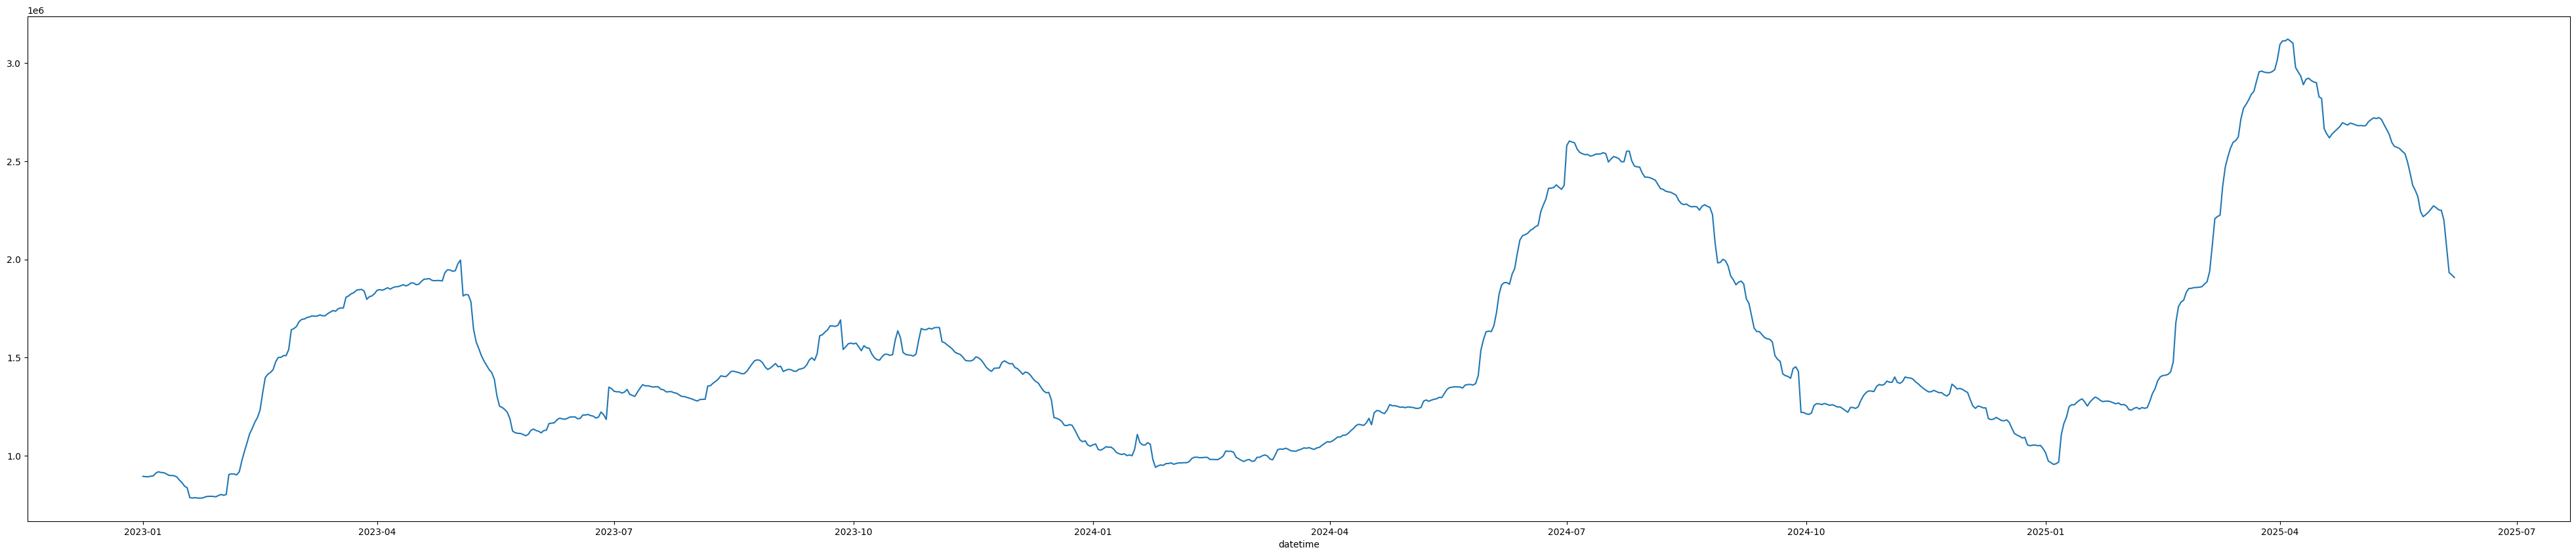

In [203]:
df = pd.read_csv('./data/BTC factors/supply/BTC_10m_active_3m_6m.csv')
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
start_time = '2023-01-01 00:00:00'
df = df.sort_values('datetime')
df.set_index(df.columns[0], inplace=True)
df = df.resample('D').mean()
df = df[start_time:]
plt.figure(figsize=(50,10))
plt.plot(df)
plt.xlabel('datetime')
plt.show()

In [150]:
df = pd.read_csv('./data/BTC factors/supply/BTC_10m_active_3m_6m.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df = df[df['datetime']>='2023-01-01']
df['date'] = df['datetime'].dt.date
df = df.groupby('date')['active_3m_6m'].mean().reset_index()
df = df.set_index('date',drop=True)


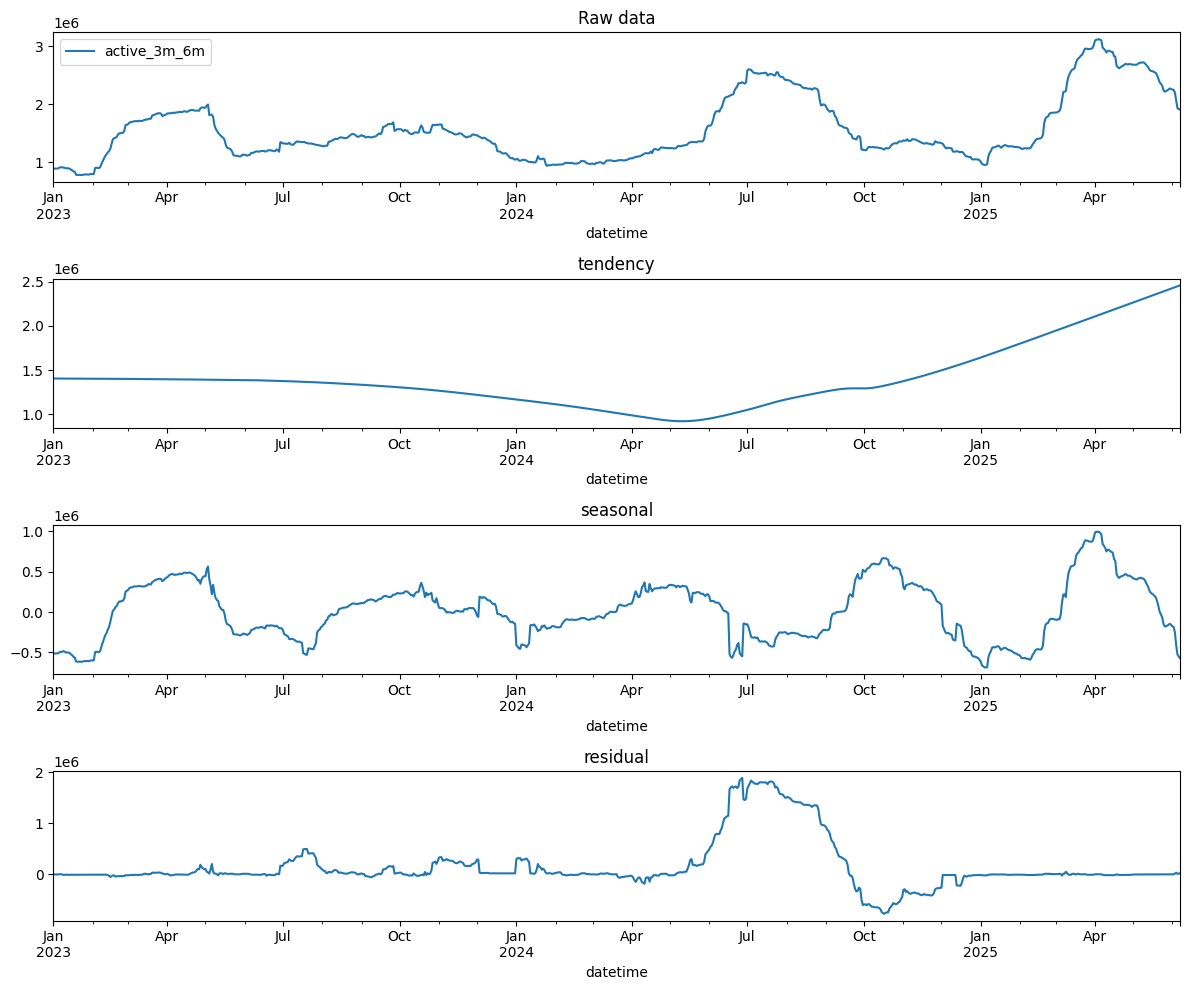

In [204]:
from statsmodels.tsa.seasonal import STL
stl = STL(df, period=168, 
            robust=True)
result_F = stl.fit()
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
result_F.observed.plot(ax=axes[0], title='Raw data')
result_F.trend.plot(ax=axes[1], title='tendency')
result_F.seasonal.plot(ax=axes[2], title='seasonal')
result_F.resid.plot(ax=axes[3], title='residual')
plt.tight_layout()
plt.show()

Train Test split

In [254]:
split = int(len(df) * 0.8)
train_data = df.iloc[:split]
test_data = df.iloc[split:]

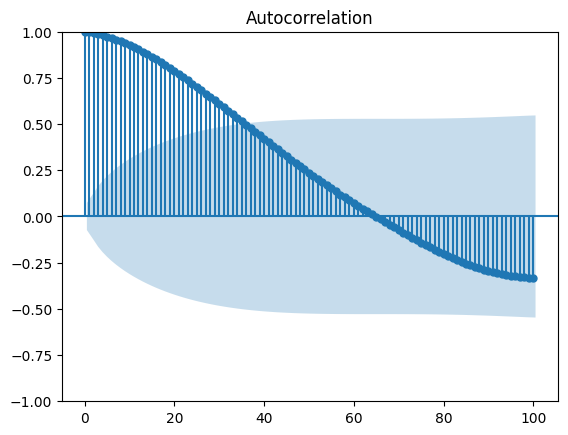

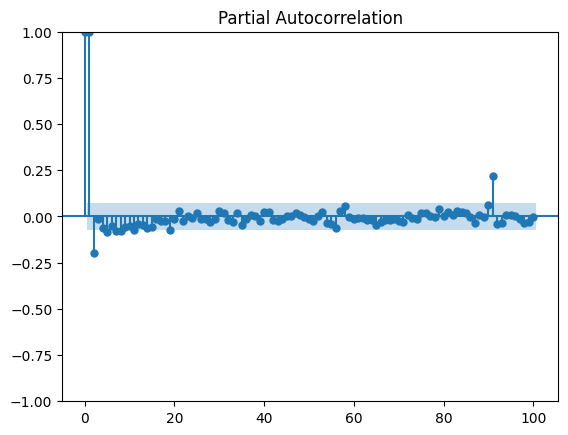

In [261]:
acffig = plot_acf(train_data,lags =100, alpha=0.05)
pacffig = plot_pacf(train_data,lags=100,alpha=0.05)

It is obvious that the MA model is not suitable for this data, but we still want to see the output of the model.

In [256]:
result_train = adfuller(train_data.dropna())
print('ADF Statistic:', result_train[0])
print('p-value:', result_train[1])

ADF Statistic: -3.0547795741711035
p-value: 0.030085785441335024


In [258]:
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore") 
res = arma_order_select_ic(train_data, max_ar=0, max_ma=20, ic=['aic'])
q = res.aic_min_order[1]
print(q)
model = ARIMA(train_data,order=(0,0,q),trend='c').fit()
params = model.params.to_dict()  
print(params)

19
{'const': 1457312.9222904735, 'ma.L1': 1.3667935524571861, 'ma.L2': 1.505002196578354, 'ma.L3': 1.5844161167412119, 'ma.L4': 1.6555008971398908, 'ma.L5': 1.6722029094826205, 'ma.L6': 1.6549076756858174, 'ma.L7': 1.618573780421594, 'ma.L8': 1.5537964127432176, 'ma.L9': 1.4558625523461484, 'ma.L10': 1.3476150782919638, 'ma.L11': 1.2151878210754363, 'ma.L12': 1.0683539365888357, 'ma.L13': 0.9217303114608449, 'ma.L14': 0.7781194929773827, 'ma.L15': 0.624198423276137, 'ma.L16': 0.46548105109238846, 'ma.L17': 0.32029793416739855, 'ma.L18': 0.19731995114007056, 'ma.L19': 0.09273171807366973, 'sigma2': 134172163005.88545}


⚠ Residual autocorrelation remains.
-617.2580661301254


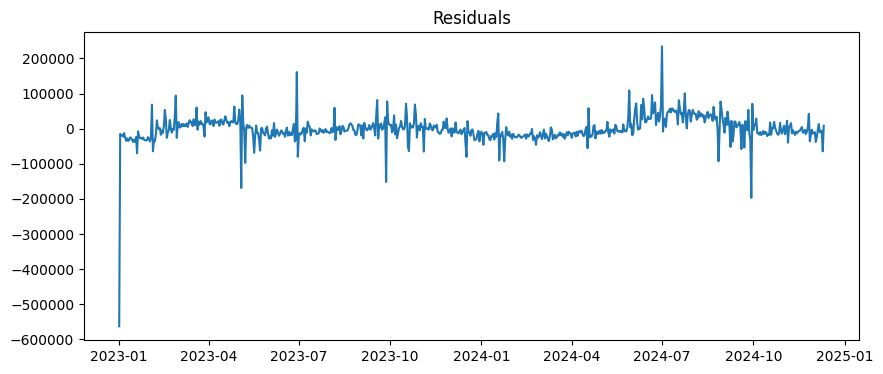

In [251]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residual = model.resid

plt.figure(figsize=(10,4))
plt.plot(residual)
plt.title("Residuals")

lb = acorr_ljungbox(residual, lags=[10], return_df=True)
p = lb['lb_pvalue'].iloc[0]
if p < 0.05:
    print("⚠ Residual autocorrelation remains.")
else:
    print("✅ Residuals white-noise-like.")
print(sum(residual)/len(residual))  

Prediction

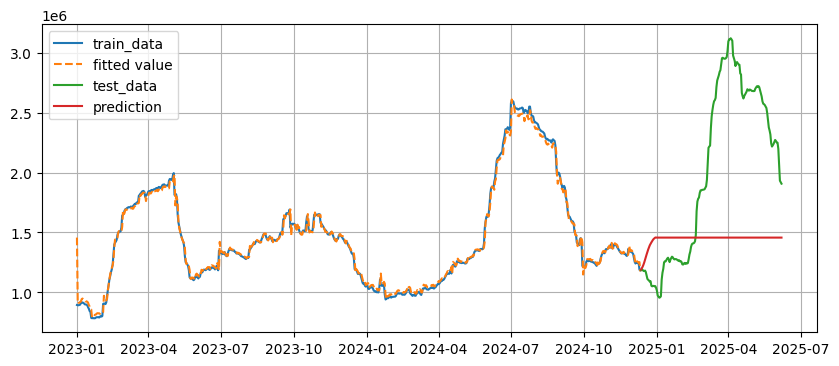

In [268]:
nsteps = len(test_data)
fit = model.fittedvalues
pred = model.forecast(nsteps)
plt.figure(figsize=(10,4))
plt.plot(train_data,label='train_data')
plt.plot(fit,label='fitted value',linestyle='--')
plt.plot(test_data,label = 'test_data')
plt.plot(pred,label='prediction')
plt.grid()
plt.legend()
plt.show()

Evaluation

In [270]:
prediction_data_value = df['active_3m_6m'][-nsteps:]
MSE = np.mean((pred-prediction_data_value)**2)
MAE = np.mean(np.abs(pred-prediction_data_value))
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((pred-prediction_data_value)/prediction_data_value))
MASE = np.mean(np.abs(prediction_data_value-pred))/np.mean(np.abs(np.array(prediction_data_value[1:])-np.array(prediction_data_value[:-1])))
result= [{'Method':'Moving Average','RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'MASE':MASE}]
result_frame = pd.DataFrame(result)
result_frame

,Method,RMSE,MAE,MAPE,MASE
0,Moving Average,903103.81927,737834.590318,0.323855,29.933073


Very bad prediction